In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

import tensorflow as tf
import tensorflow_hub as hub
import keras
import glob,os, random
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import leaf_utils

In [2]:
data_dir = r"C:\Users\Ven\Desktop\Cash-Counterfeat\model\data"
train_dir = data_dir + "/train"
valid_dir = data_dir + "/valid"

In [3]:
# acquiring a list of all class names
class_names = os.listdir(train_dir)
print(class_names)

['fake_1k', 'fake_500', 'real_1k', 'real_500']


In [19]:
HEIGHT = 224
WIDTH = 224
CHANNELS = 3
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224, 3)
EPOCHS = 20

n_classes = len(class_names)
n_classes

4

In [20]:
img_size = (HEIGHT, WIDTH)

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode='categorical'
)

Found 800 images belonging to 4 classes.
Found 200 images belonging to 4 classes.


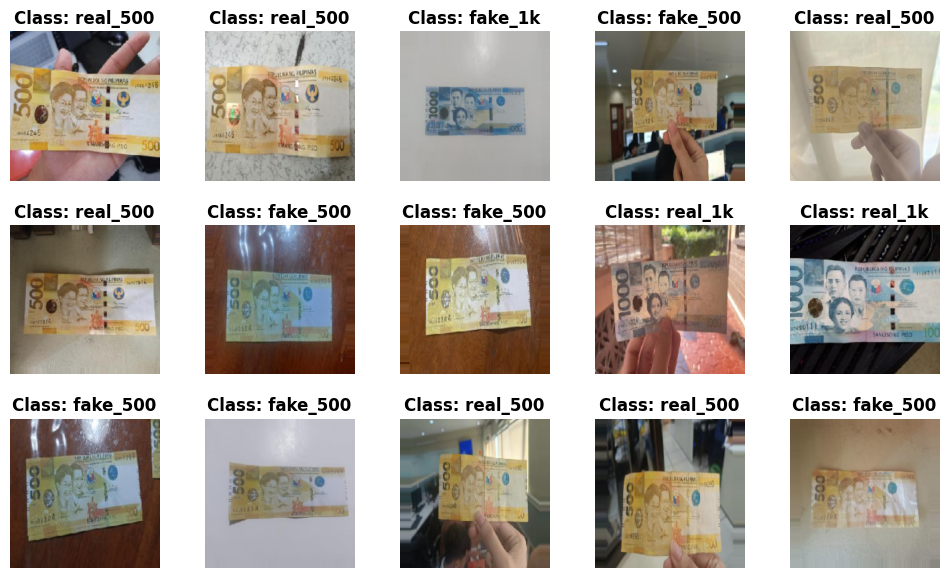

In [21]:
# Get the class indices and names from the train generator
class_indices = train_generator.class_indices
label_to_name = {idx: name for name, idx in class_indices.items()}
samples = train_generator.__next__()  # next fetches the image from the object. Each run gives a new set of images in the training set

images = samples[0]
target = samples[1]

plt.figure(figsize=(12, 12))
for i in range(15):
    plt.subplot(5, 5, i + 1)
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.imshow(images[i])
    
    # Get the class index from one-hot encoded target
    label_idx = tuple(target[i]).index(1)
    class_name = label_to_name[label_idx]
    
    plt.title(f"Class: {class_name}")
    plt.axis('off')

plt.show()

In [22]:
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, Rescaling

augmentation_layer = tf.keras.Sequential([
    RandomZoom(0.2, seed=42)
    # tf.keras.layers.RandomTranslation(0.2, 0.2, seed=SEED)
])

In [23]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()
#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=10)

# EarlyStopping callback to stop training if val_loss does not improve after n epochs
earlystop_cb = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

checkpoint_cb = ModelCheckpoint('model.h5', save_best_only=True)

CALLBACKS = [my_callback, rop_callback, earlystop_cb]

In [24]:
LR = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    LR, decay_steps=10, decay_rate=0.9)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

In [25]:
CURRENT_RUN_DIR = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetv2"

In [27]:
from tensorflow.keras.applications import MobileNetV2

mobnetv2_model = leaf_utils.get_4_part_seq_model(MobileNetV2,
                                                 augmentation_layer,
                                                 input_shape=INPUT_SHAPE,
                                                 n_classes=n_classes)


train_mobnetv2 = leaf_utils.get_model_train_with_storing('mobnetv2', CURRENT_RUN_DIR)
trained_mobnetv2, mobnetv2_history = train_mobnetv2(mobnetv2_model, train_generator,  test_generator, optimizer, epochs=10)

Epoch 1/10
50/50 [==============================] - 118s 2s/step - loss: 0.9659 - accuracy: 0.6463 - val_loss: 0.3897 - val_accuracy: 0.8350
Epoch 2/10
50/50 [==============================] - 95s 2s/step - loss: 0.2976 - accuracy: 0.8850 - val_loss: 0.2325 - val_accuracy: 0.9200
Epoch 3/10
50/50 [==============================] - 90s 2s/step - loss: 0.2141 - accuracy: 0.9325 - val_loss: 0.2029 - val_accuracy: 0.9300
Epoch 4/10
50/50 [==============================] - 90s 2s/step - loss: 0.1683 - accuracy: 0.9550 - val_loss: 0.1823 - val_accuracy: 0.9450
Epoch 5/10
50/50 [==============================] - 90s 2s/step - loss: 0.1562 - accuracy: 0.9550 - val_loss: 0.1914 - val_accuracy: 0.9500
Epoch 6/10
50/50 [==============================] - 95s 2s/step - loss: 0.1736 - accuracy: 0.9488 - val_loss: 0.1826 - val_accuracy: 0.9500
Epoch 7/10
50/50 [==============================] - 93s 2s/step - loss: 0.1603 - accuracy: 0.9513 - val_loss: 0.1696 - val_accuracy: 0.9450
Epoch 8/10
50/50 [=

In [31]:
class_dict = {
    "0": "fake_1k",
    "1": "fake_500",
    "2": "real_1k",
    "3": "real_500"
}

In [1]:
from tensorflow.keras.models import model_from_json
# Load model architecture from JSON file
model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\mobnetv2_model.json"
with open(model_path, 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

# Load model weights
weights_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\weights\mobnetv2.hdf5"
model.load_weights(weights_path)

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, None, None, None)  0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_generator)

# Obtain the true labels from the test_generator
true_labels = test_generator.classes

# Generate the classification report
report = classification_report(true_labels, predictions.argmax(axis=1), target_names=class_names)
print(report)

13/13 [==============================] - 18s 1s/step
              precision    recall  f1-score   support

     fake_1k       0.94      0.92      0.93        50
    fake_500       0.94      0.96      0.95        50
     real_1k       0.94      0.94      0.94        50
    real_500       0.96      0.96      0.96        50

    accuracy                           0.94       200
   macro avg       0.94      0.94      0.94       200
weighted avg       0.94      0.94      0.94       200



In [54]:
import seaborn as sns

# Plot accuracy and loss
def plot_acc_loss(history):
    plt.figure(figsize=(12, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Generate confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
    plt.yticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
    plt.title('Confusion Matrix')
    plt.show()

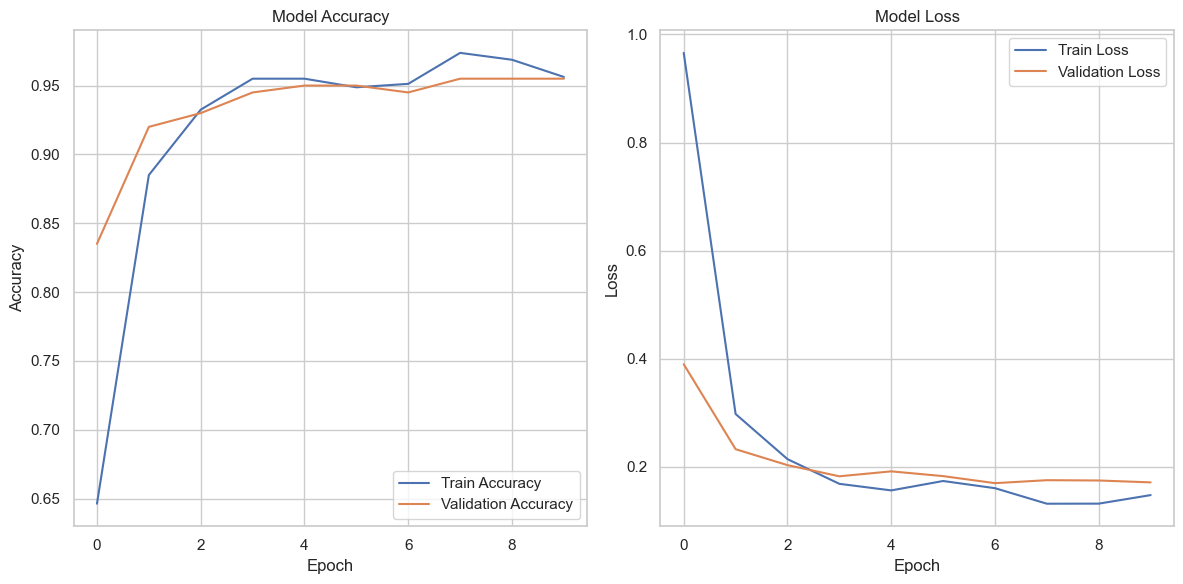

In [46]:
# Plot accuracy and loss
plot_acc_loss(mobnetv2_history)

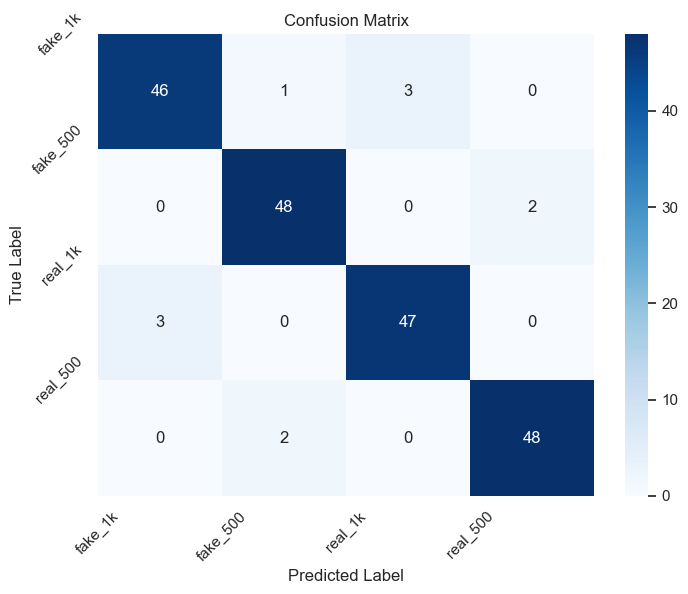

In [55]:
# Plot confusion matrix
class_names = test_generator.class_indices.keys()
plot_confusion_matrix(true_labels, predictions.argmax(axis=1), class_names)

In [3]:
# Save the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
# converter.experimental_new_converter = True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]

tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_path = r"C:\Users\Ven\Desktop\CashCF Data\models\categorical\mobnetV2\tflite\mobnetV2.tflite"
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Ven\AppData\Local\Temp\tmph4hjuazb\assets


INFO:tensorflow:Assets written to: C:\Users\Ven\AppData\Local\Temp\tmph4hjuazb\assets
